In [1]:
# !conda install --yes seaborn

In [2]:
# Compare Algorithms
import pandas
import numpy as np
import matplotlib.pyplot as plt

#import method releated to evaluation
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit, cross_val_score, GridSearchCV

#transformers
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

#export the models from the sklearn library
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
%matplotlib inline


## Continue with Diabetes Dataset - Prepare Dataset
We will use the Pima Indians diabetes dataset to explore the different evaluation methods provided in sklearn. 
It contains 768 rows and 9 features and is used to build models that can predict the onset of diabetes based on diagnostic measures.
Description of the features follow:

0 preg = Number of times pregnant

1 plas = Plasma glucose concentration a 2 hours in an oral glucose tolerance test

2 pres = Diastolic blood pressure (mm Hg)

3 skin = Triceps skin fold thickness (mm)

4 test = 2-Hour serum insulin (mu U/ml)

5 mass = Body mass index (weight in kg/(height in m)^2)

6 pedi = Diabetes pedigree function

7 age = Age (years)

8 class = Class variable (1:tested positive for diabetes, 0: tested negative for diabetes)"

All of the values in the file are numeric, specifically floating point values. 
We will learn how to load the file first, then use it with sklearn by dividing the data into class labels (Y) and feature sets (X). We dont need to split it into test/train as we are going to use scklearn methods to do that.

In [32]:
# load dataset
filename = "data/pima-indians-diabetes.data.csv"
#lets add some column names as the CSV file does not have these
names = ['pregnancies', 'glucose', 'bp', 'skin', 'insuline', 'bmi', 'pedi', 'age', 'class']
#lets use the convinient pandas library to read and form a data frame of our dataset
dataframe = pandas.read_csv(filename, names=names)

seed =100 #useful for random generators

array = dataframe.values
# divide data into label and feature sets.
# this dataset has its class column in location 8
X = array[:,0:8] # upto column index 7 i.e. 0 to 7
y = array[:,8] # 8th column index



array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

## Prepare models
We will use the scikitLearn library to access a bunch of ML models already avaiable
and run each of them on the diabetes classification dataset. 

For instance with a statement such as: 
models.append(('ANN', MLPClassifier()))

we are using sciktlearn's neural net classifier which is a Multi-layer Perceptron classifier. 

We will be using the default settings for each of the classifiers. 

We encourage you to look up the scikitlearn documentation on classifiers to understand the different hyper-parameter settings and how you might change them (http://scikit-learn.org/stable/)

In [4]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='rbf', gamma=0.7, C=1.0)))
models.append(('ANN', MLPClassifier()))


In [27]:
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

By evaluating our classifier performance on data that has been seen during training, we could get false confidence in the predictive power of our model. In the worst case, it may simply memorize the training samples but completely fails classifying new, similar samples -- we really don't want to put such a system into production!
Instead of using the same dataset for training and testing (this is called "resubstitution evaluation"), it is much much better to use a train/test split in order to estimate how well your trained model is doing on new data.

## k-Fold Cross validation
 
Often (labeled) data is precious, but with the previous hold-out (test_train_split) approach we can use only 
~ 3/4 of our data for training. On the other hand, we will only ever try to apply our model 1/4 of our data for testing. A common way to use more of the data to build a model, but also get a more robust estimate of the generalization performance, is to use cross-validation. 

In cross-validation, the data is split repeatedly into a training and non-overlapping test-sets, with a separate model built for every pair. Each split of the data is called a fold. 
Essentially the algorithm is trained on k-1 folds with one held back and tested on the held back fold. This is repeated so that each fold of the dataset is given a chance to be the held back test set.
The most common way to do cross-validation is k-fold cross-validation, in which the data is first split into k (often 5 or 10) equal-sized folds, and then for each iteration, one of the k folds is used as test data, and the rest as training data.

The test-set scores are then aggregated for a more robust estimate.

This way, each data point will be in the test-set exactly once, and we can use all but a k'th of the data for training. Let us apply this technique to evaluate the KNeighborsClassifier algorithm on the Iris dataset:

Cross validation is an approach that you can use to estimate the performance of a machine learning algorithm with less variance than a single train-test set split.

After running cross validation you end up with k different performance scores that you can summarize using a mean and a standard deviation.
The result is a more reliable estimate of the performance of the algorithm on new data given your test data. It is more accurate because the algorithm is trained and evaluated multiple times on different data.

The choice of k must allow the size of each test partition to be large enough to be a reasonable sample of the problem, whilst allowing enough repetitions of the train-test evaluation of the algorithm to provide a fair estimate of the algorithms performance on unseen data. For modest sized datasets in the thousands or tens of thousands of records, k values of 3, 5 and 10 are common.

In the example below we use 10-fold cross validation.
The model_selection.KFold forms the kfold and model_selection.cross_val_score aggregates the scores (specified here as scoring = 'accuracy') providing mean and standard deviation over the specified number of runs (specified here as n_splits=10).

For more details you can also read up on the function at http://scikit-learn.org/stable/modules/cross_validation.html

LR: 0.769515 (0.048411)
LDA: 0.773462 (0.051592)
KNN: 0.726555 (0.061821)
CART: 0.693934 (0.063092)
NB: 0.755178 (0.042766)
SVM: 0.651025 (0.072141)
ANN: 0.665379 (0.053578)


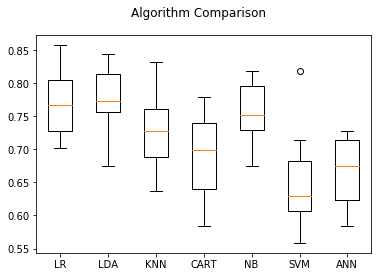

In [5]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

##iterate through each model
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [6]:
names

['LR', 'LDA', 'KNN', 'CART', 'NB', 'SVM', 'ANN']

In [7]:
cv_results.mean()

0.6653793574846206

In [8]:
results

[array([0.7012987 , 0.81818182, 0.74025974, 0.71428571, 0.77922078,
        0.75324675, 0.85714286, 0.80519481, 0.72368421, 0.80263158]),
 array([0.7012987 , 0.83116883, 0.75324675, 0.67532468, 0.77922078,
        0.76623377, 0.84415584, 0.81818182, 0.76315789, 0.80263158]),
 array([0.63636364, 0.83116883, 0.7012987 , 0.63636364, 0.71428571,
        0.75324675, 0.74025974, 0.80519481, 0.68421053, 0.76315789]),
 array([0.62337662, 0.77922078, 0.68831169, 0.58441558, 0.68831169,
        0.74025974, 0.74025974, 0.76623377, 0.61842105, 0.71052632]),
 array([0.67532468, 0.80519481, 0.75324675, 0.71428571, 0.72727273,
        0.76623377, 0.80519481, 0.81818182, 0.73684211, 0.75      ]),
 array([0.58441558, 0.71428571, 0.55844156, 0.61038961, 0.64935065,
        0.61038961, 0.81818182, 0.67532468, 0.68421053, 0.60526316]),
 array([0.58441558, 0.68831169, 0.58441558, 0.66233766, 0.71428571,
        0.71428571, 0.72727273, 0.63636364, 0.72368421, 0.61842105])]

## When do we Need Stratification?
By default, cross_val_score will use StratifiedKFold for classification, which ensures that the class proportions in the dataset are reflected in each fold. If you have a binary classification dataset with 90% of data point belonging to class 0, that would mean that in each fold, 90% of datapoints would belong to class 0. If you would just use KFold cross-validation, it is likely that you would generate a split that only contains class 0. It is generally a good idea to use StratifiedKFold whenever you do classification.

In [9]:
kfold = StratifiedKFold(n_splits=5)
idx = 0
for train, test in kfold.split(X, y):
    print("Fold: ", idx)
    print(test)
    idx += 1

Fold:  0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153]
Fold:  1
[154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241

By default, cross_val_score will use StratifiedKFold for classification, which ensures that the class proportions in the dataset are reflected in each fold. If you have a binary classification dataset with 90% of data point belonging to class 0, that would mean that in each fold, 90% of datapoints would belong to class 0. If you would just use KFold cross-validation, it is likely that you would generate a split that only contains class 0. It is generally a good idea to use StratifiedKFold whenever you do classification.

## Iris Dataset - Understanding Stratified Cross-Fold Validation


The labels in iris are sorted, which means that if we split the data without stratification then the first fold will only have the label 0 in it, while the last one will only have the label 2.
To avoid this we want stratification to select instances for folds from different areas of the dataset to ensure a class distribution that is representative of the original dataset. 

Next we will attempt to understand this different by plotting the locations from where instances are selected for folds over the full dataset.

We will do this by plotting the results for both stratified and non-stratified versions.
We do this by creating a binary vectored mask which marks the location  /index of each 
test instances selected from the dataset.

In [10]:
#lets load the Iris dataset which is part of the sklearn library
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target
class_names = iris.target_names

print("Number of instances: ", len(X))

Number of instances:  150


## Iris Dataset - Visualising Membership of Instances in Folds

In [11]:
# to help with visualisation
# lets define a generic plot method
# which takes cross-validation folds together with the dataset (X) and class labels (y)
def plot_cv(cv, X, y):
    masks = []
    for train, test in cv.split(X, y):
        mask = np.zeros(len(y), dtype=bool) # initialise a mask of length X
       
        mask[test] = 1 # set the mask location True if the corresponding instance was selected as a test instance
        #print(test)
        #print(mask)
        masks.append(mask) # append the mask from this fold
    
    #matshow displays an array as an impage
    # cmap is a colour map using the mask to show area where test instance indexes were extracted
    # each mask corresponding to a fold is displayed in a row
    plt.matshow(masks, cmap='gray_r')

Stratified


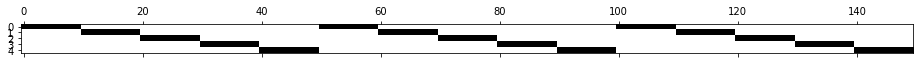

In [12]:
print("Stratified")
plot_cv(StratifiedKFold(n_splits=5), X, y)

Not Stratified


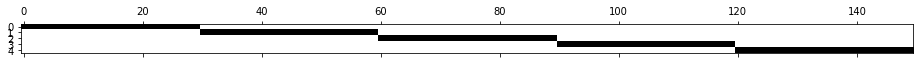

In [13]:

print("Not Stratified")
plot_cv(KFold(n_splits=5), X, y)

# Exercise
- Can you understand the difference due to stratification from the graphoc above?
- There is also a version of stratification for the basic train_test_split that we worked with earlier. It is called StratifiedShuffleSplit. We return to it at the end of this lab but you can find out more about it here http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

## Iris Dataset - StratifiedShuffleSplit to generate several train-test splits
This generator randomly splits the data into train and test repeatedly. With stratification it ensures that the split maintains class distribution in both train and test. 
This allows the user to specify the number of repetitions and the training/test set size independently.

Note this is very similar to test-train-splits but is stratified by default and by specifying n_splits it repeatedly creates several train-test splits to run models and aggregation an average accuracy over all the train-test splits. 

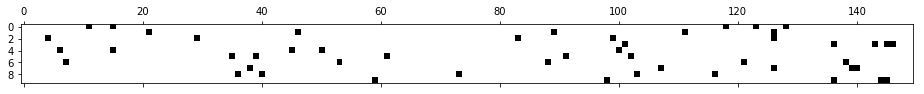

In [14]:
plot_cv(ShuffleSplit(n_splits=10, test_size=.03, random_state=seed), iris.data, iris.target)

If you look closely you will notice that the first row is not well distributed in terms of where the test instances are being picked. Remember that in the Iris dataset the instances are originally ordered by class.
Ideally what we want is to select test instances from across the avaiable classes. 
You can now visualise this using the StratifiedShuffleSplit version.
Note that it is unlikly that you will need to select 0.03 percent only as test set; but we have used this very low value so that you can dive into and understand the plot better. 

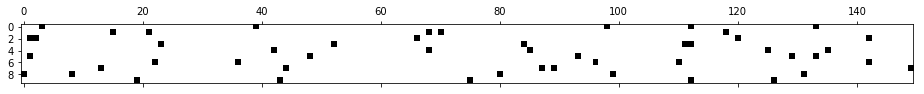

In [15]:
plot_cv(StratifiedShuffleSplit(n_splits=10, test_size=.03, random_state=seed), iris.data, iris.target)

You can use all of these cross-validation generators with the cross_val_score method:

In [16]:
# evaluate each model in turn
# use 10 iterations of cross validation
results = []
names = []
scoring = 'accuracy'

##iterate through each model
for name, model in models:
    kfold = StratifiedShuffleSplit(n_splits=10, random_state=seed, test_size=.2)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.953333 (0.030551)
LDA: 0.983333 (0.016667)
KNN: 0.986667 (0.016330)
CART: 0.963333 (0.037859)
NB: 0.966667 (0.029814)
SVM: 0.980000 (0.016330)


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt

ANN: 0.973333 (0.020000)


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Exercise
In all our evaluations so far we have been working with accuracy as the main metric of comparison. 

However there are several other scoring metrics (e.g. precision, recall, f1-score, support) other than "accuracy" that can be used to compare results. Modify the code above to explore these metrics. Note that in Scikit, default "precision", "recall" and "f1-score" are for binary class only. For multi-class, you will need to use a variant that sepcifies the averaging method e.g. "precision_micro". Other averaging options are "macro" and "weighted". You can read about the different metrics here: http://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

LeaveOneOut (or LOO) is a simple cross-validation approach. 
You can import as "from sklearn.model_selection import LeaveOneOut". Modify the code above to explore LeaveOneOut. 

Each learning set is created by taking all the samples except one, the test set being the sample left out. Thus, for  samples, we have  different training sets and  different tests set. This cross-validation procedure does not waste much data as only one sample is removed from the training set. However it is time consuming ans so mainly used with small datasets. 
You can read more about it here http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut

## MNIST - Advance Evaluation Setup - How to use Grid Search CV with MNIST?
GridSearchCV carries out an exhaustive search over specified parameter values for a classifier.

Like other cross validation methods, Gridsearch splits up your test set into eqally sized folds, 
uses one fold as test and the rest for training. 

In this way it optimizes as many classifiers as parts you split your data into.

You need to specify the number of folds, a classifier (such as MLP), and a Grid of parameters you may want to optimize as follows:

sampling with replacement ... this will take a moment ...
shape of data sampled: (600, 785)
shape of X: (600, 784)
shape of y: (600,)


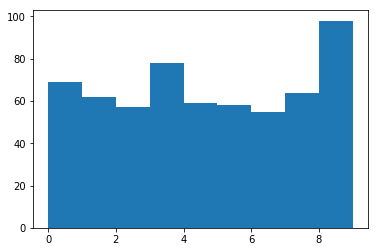

In [17]:
# load dataset
filename = "data/mnist_60K.csv"
print('sampling with replacement ... this will take a moment ...')

#lets use the convinient pandas library to read and form a data frame of our dataset
mnist = pandas.read_csv(filename, header=None)
#df.head()

#store the class names for plotting later on
class_names = []
for i in range(0,10):
    class_names.append(str(i))


#use a very small fraction of the 60K dataset
array = mnist.sample(frac=0.01, replace=True).values
print('shape of data sampled:', array.shape)


X = array[:,1:] 
y = array[:,0] # mnist has its class column in first position
print('shape of X:', X.shape)
print('shape of y:', y.shape)
labels = np.asfarray(y)


#basic plot to visualise the histogram of the class values
plt.hist(labels, bins=[0,1,2,3,4,5,6,7,8,9]) 
plt.show()


## MNIST - Setup a grid search to explore a variety of parameters relevant to a classifier
In this example we will setup grid search for a MLPClassifier model (i.e. a neural network) from the scikitLearn library. 
Therefore the grid search will explore a variety of parameters that are relevant to this specific classifier. 

Obviously if you are working with a different classifier then you must use and explore parameters relevant to that specific classifier. 

For the MLPClassifier we explore different parameter settings for activation functions, weight update methods and hidden layer sizes.
Details on parameters appear http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [18]:
param_grid = [
        {
            'activation' : ['identity', 'logistic', 'relu'], 
            'solver' : ['lbfgs', 'adam'],
            'hidden_layer_sizes': [(10,),(30,)] # a single hidden layer
        }
       ]

In [19]:
#print(X[0])
#print(X[1])
#print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

print("Searching for best parameters - this will take a moment ...")
clf = GridSearchCV(MLPClassifier(), param_grid, cv=5, scoring='accuracy')
clf.fit(X_train,y_train)
print("Best parameters set found on validation:")
print(clf.best_score_)
print(clf.best_params_)

Searching for best parameters - this will take a moment ...


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt

Best parameters set found on validation:
0.7880952380952381
{'activation': 'logistic', 'hidden_layer_sizes': (30,), 'solver': 'adam'}


# MNIST - Use the best found parameter combination to create a model

We use the parameters that were returned by GridSearchCV; (in our example this will be clf.best_params_) to create the new model.
We also use two new method to provide some useful statistics about the model performance: classification_report and confusion_matrix

In [20]:
print("Best estimator found by grid search:")
print(clf.best_params_)

print("Predicting on the test set")
y_pred = clf.predict(X_test)
print("Target labels: ", y_test)
print("Predicted labels: ", y_pred)

print(classification_report(y_test, y_pred, target_names=class_names))


y_test2 = pandas.Series(y_test)
y_pred2 = pandas.Series(y_pred)

pandas.crosstab(y_test2, y_pred2, rownames=['True'], colnames=['Predicted'], margins=True)

Best estimator found by grid search:
{'activation': 'logistic', 'hidden_layer_sizes': (30,), 'solver': 'adam'}
Predicting on the test set
Target labels:  [2 4 2 2 8 9 9 1 3 9 0 3 9 3 8 0 1 0 6 4 3 0 4 3 3 9 3 4 5 7 0 5 2 9 3 2 2
 8 7 5 0 2 7 8 7 2 4 3 8 4 7 4 6 4 9 9 8 5 8 5 4 0 3 0 1 2 1 7 4 7 9 9 2 1
 3 6 7 7 4 1 7 4 0 0 4 1 7 6 5 9 6 3 7 3 5 1 8 6 8 3 0 2 5 3 0 6 7 7 2 9 0
 7 0 7 3 6 3 8 9 2 5 0 0 4 2 4 3 5 4 7 6 3 0 5 1 6 8 0 7 1 2 9 1 1 1 4 6 1
 7 2 4 0 2 1 2 1 8 6 8 6 0 0 3 6 4 6 5 4 6 4 1 2 3 0 6 1 0 5 8 8]
Predicted labels:  [2 4 2 2 8 4 9 1 3 4 0 3 9 2 6 0 8 0 6 4 3 0 4 3 8 7 3 4 6 7 0 3 2 0 3 2 2
 8 7 3 0 2 8 8 4 4 4 3 8 4 7 9 6 4 4 7 8 2 8 6 4 0 7 0 1 8 1 7 4 7 9 9 2 8
 3 6 7 7 0 1 7 4 0 0 9 1 7 2 0 9 6 5 7 3 5 1 8 6 8 3 0 8 2 7 0 6 7 7 2 4 0
 7 0 7 3 2 3 1 9 1 6 0 0 4 2 9 2 3 9 7 6 3 0 3 1 6 8 0 7 1 5 9 8 1 1 4 6 1
 7 0 4 0 8 1 0 1 8 0 1 6 0 0 3 6 4 6 4 7 6 4 1 2 3 0 6 1 0 5 8 8]
             precision    recall  f1-score   support

          0       0.79      1.00      0.8

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,23,0,0,0,0,0,0,0,0,0,23
1,0,15,0,0,0,0,0,0,3,0,18
2,2,1,11,0,1,1,0,0,3,0,19
3,0,0,2,15,0,1,0,2,1,0,21
4,1,0,0,0,15,0,0,1,0,4,21
5,1,0,2,4,1,2,3,0,0,0,13
6,1,0,2,0,0,0,14,0,0,0,17
7,0,0,0,0,1,0,0,17,1,0,19
8,0,2,0,0,0,0,1,0,12,0,15


# MNIST - How to plot and visualise a confusion matrix?
For this we will use the heatmap function from the seaborn library. You can compare the quality of the graph provided with and without seaborn.

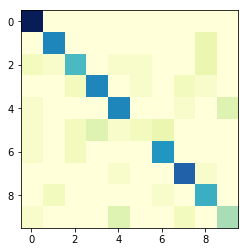

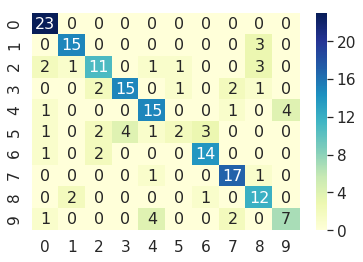

In [21]:
conf=confusion_matrix(y_test, y_pred)
plt.imshow(conf, cmap="YlGnBu", interpolation='None')
plt.show()

# or we can use a heatmap from the seaborn library
import seaborn as sn
df_cm = pandas.DataFrame(conf, range(10), range(10))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="YlGnBu", annot=True, annot_kws={"size": 16})# font size

# Exercise
How might you conduct a grid search with a different classifier from sklearn? For instance the SVM classifier?
You can read about this classifier and its paramemeters that you could apply grid search to here http://scikit-learn.org/stable/modules/svm.html